<a href="https://colab.research.google.com/github/gajalgarg09/hizenAI_Assignment/blob/main/hizenAI_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report , roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder , StandardScaler
from imblearn.over_sampling import SMOTE

In [8]:
# Loading Dataset

data = pd.read_csv('events.csv' , parse_dates = ['event_time'])

data['event_time'] = pd.to_datetime(data['event_time'])


#  parse_dates = ['event_time'] -> automatically converts the event_time column to
# datetime format while reading the dataset itherwise pandas will read events_time
# as strings

In [9]:
# EDA (Exploratory Data Analysis)

print('Data Overview : ')
print(data.head())

print("\n Basic Information :")
print(data.info())

print(" \n Statistics Summary : ")
print(data.describe())

Data Overview : 
                 event_time event_type  product_id          category_id  \
0 2020-09-24 11:57:06+00:00       view     1996170  2144415922528452715   
1 2020-09-24 11:57:26+00:00       view      139905  2144415926932472027   
2 2020-09-24 11:57:27+00:00       view      215454  2144415927158964449   
3 2020-09-24 11:57:33+00:00       view      635807  2144415923107266682   
4 2020-09-24 11:57:36+00:00       view     3658723  2144415921169498184   

                   category_code        brand   price              user_id  \
0          electronics.telephone          NaN   31.90  1515915625519388267   
1    computers.components.cooler       zalman   17.16  1515915625519380411   
2                            NaN          NaN    9.81  1515915625513238515   
3  computers.peripherals.printer       pantum  113.81  1515915625519014356   
4                            NaN  cameronsino   15.87  1515915625510743344   

  user_session  
0   LJuJVLEjPT  
1   tdicluNnRY  
2   4TMArHtX

In [10]:
# Checking for missing values
print("\n Missing Values: ")
print(data.isnull().sum())

# it prints the count of missing values in each column of the dataset


 Missing Values: 
event_time            0
event_type            0
product_id            0
category_id           0
category_code    236219
brand            212364
price                 0
user_id               0
user_session        165
dtype: int64


In [11]:
# Handling missing values

categorical_cols = data.select_dtypes(include = ['object']).columns

# We'll impute 'category_code' with 'Unknown'
data['category_code'] = data['category_code'].fillna('Unknown')

# We'll impute 'brand' with 'Unknown'
data['brand'] = data['brand'].fillna('Unknown')

# We'll impute 'user_session' with 'Unknown'
data['user_session'] = data['user_session'].fillna('Unknown')

In [12]:
# Checking for missing values after handling

print("\n Missing Values: ")
print(data.isnull().sum())


 Missing Values: 
event_time       0
event_type       0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
user_session     0
dtype: int64


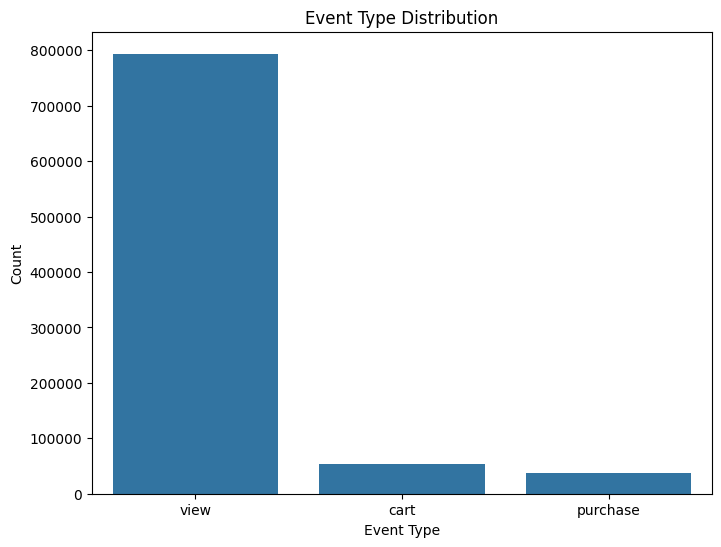

In [13]:
# Event Type Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='event_type', data=data, order=data['event_type'].value_counts().index)
plt.title('Event Type Distribution')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.show()

In [14]:
# User behaviour analysis

user_events = data.groupby('user_id')['event_type'].value_counts().unstack(fill_value = 0)
print("\n User Events Summary : ")
print(user_events.head())


 User Events Summary : 
event_type           cart  purchase  view
user_id                                  
1515915625353226922     0         0     1
1515915625353230067     0         0     1
1515915625353230683     0         0    13
1515915625353230922     0         0     1
1515915625353234047     0         0    36


In [15]:
# Defining Churn -> users who have not made a purchase in last X days
X_days = 30
latest_date = data['event_time'].max()

last_purchase_date = data[data['event_type'] == 'purchase'].groupby('user_id')['event_time'].max()
last_purchase_date = pd.to_datetime(last_purchase_date)

user_last_purchase = last_purchase_date.apply(lambda x : (latest_date - x).days)

churn_threshold = X_days
churn_users = user_last_purchase[user_last_purchase > churn_threshold].index

data['is_churn'] = data['user_id'].isin(churn_users).astype(int)

In [16]:
# Feature Engineering

user_features = data.groupby('user_id').agg({
    'event_time' : [
        lambda x : (latest_date - x.max()).days, # Recency
        'count' # Frequency
    ],

    'price' : 'sum' , # Monetary value
    'user_session' : 'nunique' # Session count
}).reset_index()

user_features.columns = ['user_id', 'recency' , 'frequency' , 'monetary' ,
                        'session_count']

In [17]:
# Encoding categorical features
le = LabelEncoder()
data['category_code'] = le.fit_transform(data['category_code'])

In [18]:
# Prepare dataset for modeling
data_model = data.merge(user_features , on = 'user_id' , how ='left')
data_model['target'] = data_model['is_churn']

In [19]:
# Drop non-feature columns

features = ['recency' , 'frequency' , 'monetary' , 'session_count']
X = data_model[features]
y = data_model['target']

In [20]:
# Train - Test split
x_train , x_test , y_train ,y_test = train_test_split(X,y, test_size=0.2,
                                              random_state=42, stratify = y)

In [21]:
# Handling class imbalance using SMOTE

smote = SMOTE(random_state= 42)
x_train , y_train = smote.fit_resample(x_train , y_train)

# Scale Features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [22]:
# Model Building - Random Forest
rf = RandomForestClassifier(random_state = 42)
rf.fit(x_train_scaled , y_train)

RandomForestClassifier(random_state=42)

In [23]:
# Predictions
y_pred = rf.predict(x_test_scaled)
y_proba = rf.predict_proba(x_test_scaled)[:,1]

In [25]:
# Performace Metrics
print("\n Classification Report : ")
print(classification_report(y_test , y_pred))
print("\n AUC Score : " , roc_auc_score(y_test , y_proba))


 Classification Report : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    148882
           1       0.98      0.99      0.99     28144

    accuracy                           1.00    177026
   macro avg       0.99      1.00      0.99    177026
weighted avg       1.00      1.00      1.00    177026


 AUC Score :  0.9988273732252974



 Feature importances : 
         Feature  Importance
1      frequency    0.406697
2       monetary    0.295160
0        recency    0.237792
3  session_count    0.060351


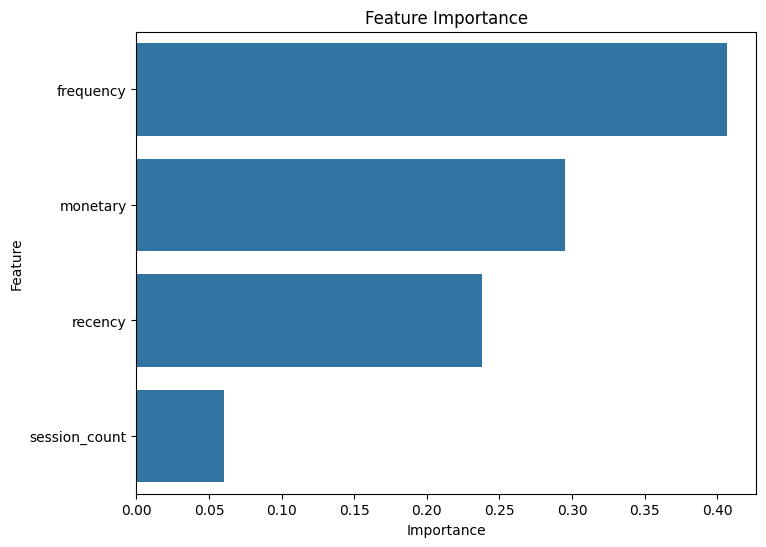

In [26]:
# Feature importance
feature_importances = pd.DataFrame({
    'Feature' : features,
    'Importance' : rf.feature_importances_
}).sort_values(by='Importance' , ascending = False)

print("\n Feature importances : ")
print(feature_importances)

plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importance')
plt.show()

In [2]:
# Recommendations
print("\nRecommendations:")
print("1. Offer personalized discounts to users with high cart-to-purchase ratios.")
print("2. Target inactive users with marketing emails or reminders within the first 30 days of inactivity.")
print("3. Focus on improving the top categories or products associated with churn.")
print("4. Use push notifications or app messages to remind users of abandoned carts and offer incentives like free shipping or discounts.")
print("5. Offer loyalty programs or reward points to users who make frequent purchases to encourage retention.")
print("6. Identify popular brands and categories among active users and promote them to at-risk users through targeted ads.")


Recommendations:
1. Offer personalized discounts to users with high cart-to-purchase ratios.
2. Target inactive users with marketing emails or reminders within the first 30 days of inactivity.
3. Focus on improving the top categories or products associated with churn.
4. Use push notifications or app messages to remind users of abandoned carts and offer incentives like free shipping or discounts.
5. Offer loyalty programs or reward points to users who make frequent purchases to encourage retention.
6. Identify popular brands and categories among active users and promote them to at-risk users through targeted ads.
